# Adding a background to the simple peakbag

I'm going to add a background fit to the simple peakbag method. The remaining caveats are:

- I will not impose a complex prior on linewidth
- I will not apply a smoothness condition
- I will not impose a complex prior on mode heights
- I am not accounting for any asphericities due to near-surface magnetic fields

The expected effect of this will be, in order:

- Increased uncertainty on linewidths
- Risk of mode flipping on the $l = 0, 2$ pairs
- Increased runtime as the mode heights are less constrained
- Possible linewidth broadening or shifting of mode frequencies if there are significant frequency shifts

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

In [4]:
target = 3632418
mal = pd.read_csv('../../../data/malatium.csv', index_col=0)
idx = np.where(mal.KIC == target)[0][0]
star = mal.loc[idx]
kic = star.KIC
numax = star.numax
dnu = star.dnu

In [5]:
sfile = glob.glob('../../../data/*{}*.pow'.format(kic))
data = ascii.read(sfile[0]).to_pandas()
ff, pp = data['col1'].values, data['col2'].values

In [6]:
# Read in the mode locs
cop = pd.read_csv('../../../data/copper.csv',index_col=0)
cop = cop[cop.l != 3]
modelocs = cop[cop.KIC == str(kic)].Freq.values[12:15]
elocs = cop[cop.KIC == str(kic)].e_Freq.values[12:15]
modeids = cop[cop.KIC == str(kic)].l.values[12:15]

lo = modelocs.min() - .25*dnu
hi = modelocs.max() + .25*dnu

sel = (ff > lo) & (ff < hi)
f = ff[sel]
p = pp[sel]

In [7]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq) * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

In [8]:
try:
    backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                        +str(kic)+'/*_fit.pkl')[0]
    with open(backdir, 'rb') as file:
        backfit = pickle.load(file)

    labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
    res = np.array([np.median(backfit[label]) for label in labels])
    res[0:6] = 10**res[0:6]
    
    phi_ = np.array([np.median(backfit[label]) for label in labels])
    phi_sigma = pd.DataFrame(backfit)[labels].cov()
    phi_cholesky = np.linalg.cholesky(phi_sigma)
    
    model = get_background(ff, *res)
    m = get_background(f, *res)
except IndexError:
    pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, pf*(cds.ppm**2/u.microhertz))
    p = pg.flatten().power.value * 2

(0, 50)

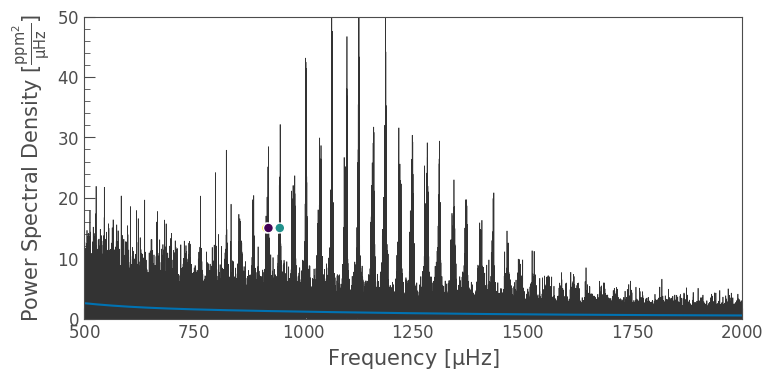

In [9]:
pg = lk.Periodogram(ff*u.microhertz, pp*(cds.ppm**2 / u.microhertz))
ax = pg.plot()
ax.plot(ff, model)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='w',zorder=100)
ax.set_xlim(500,2000)
ax.set_ylim(0, 50)

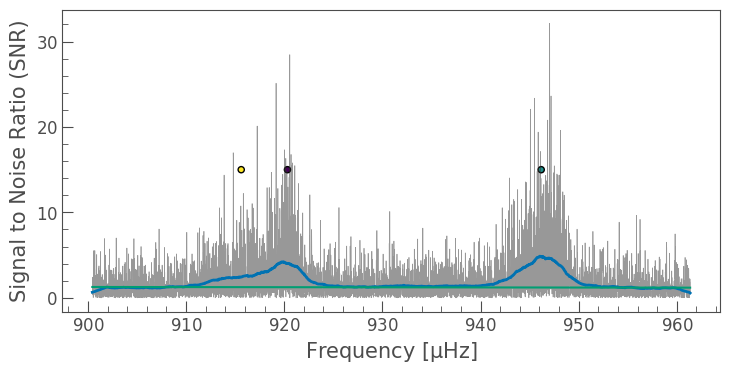

In [10]:
pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=3.).plot(ax=ax, linewidth=2)
ax.plot(f, m)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

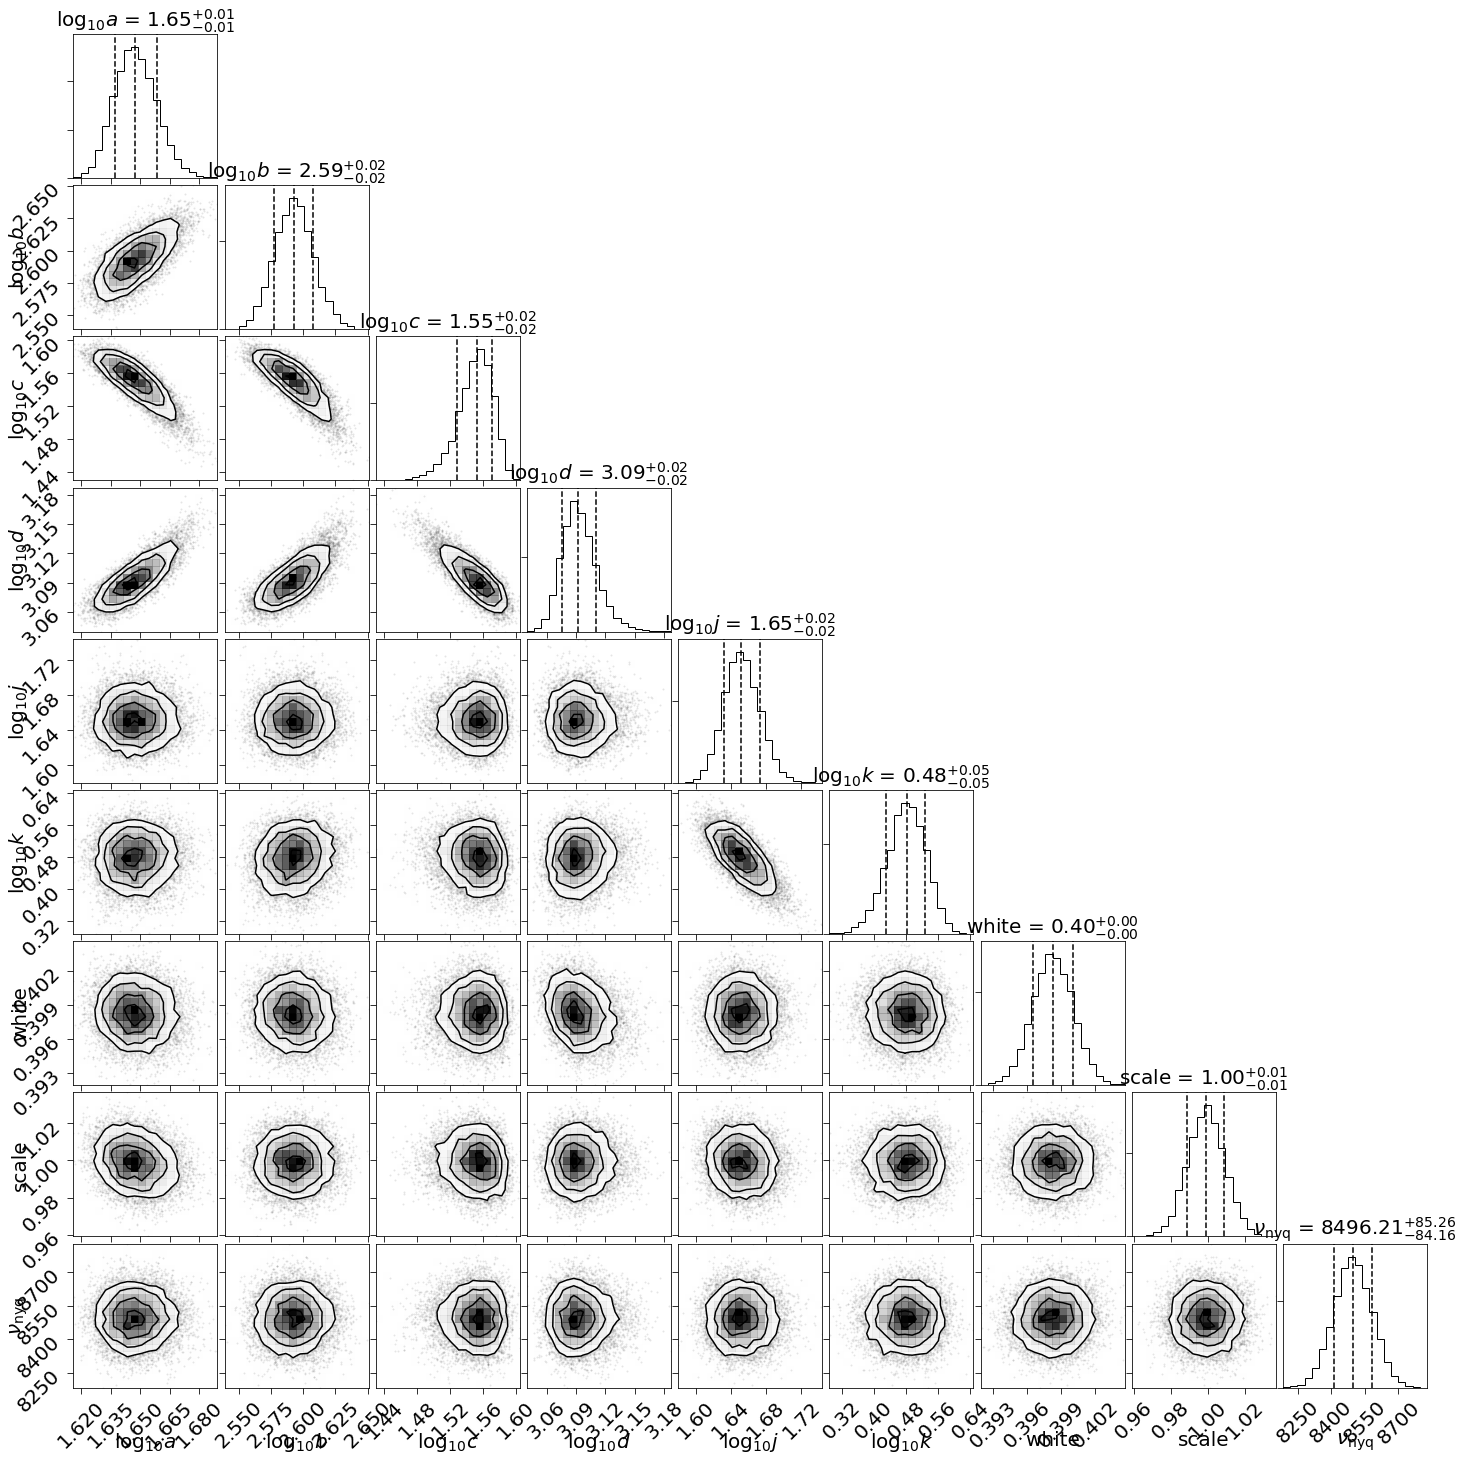

In [11]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

chain = np.array([backfit[label] for label in labels])

corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84],
                show_titles=True)
plt.show()

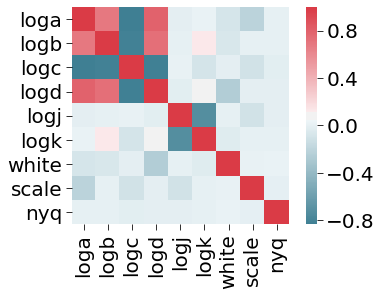

In [12]:
corr = pd.DataFrame(backfit)[labels].corr()
fig, ax = plt.subplots()
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr, cmap=cmap, square=True)

It looks like $\phi[0:6]$ are the most correlated, but I'm going to treat the whole thing with a correlation matrix to take care of those wings around the centre. If this slows stuff down too much I guess I'll just only treat the Harvey parameters.

# Build the model
Let's add the background function in...

In [13]:
class model():
    def __init__(self, f, f0_, f1_, f2_):
        self.f = f
        self.npts = len(f)
        self.M = [len(f0_), len(f1_), len(f2_)]


    def harvey(self, a, b, c):
        harvey = 0.9*a**2/b/(1.0 + (self.f/b)**c);
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return (np.sin(x)/x)**2

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(10**loga, 10**logb, 4.) \
                        +  self.harvey(10**logc, 10**logd, 4.) \
                        +  self.harvey(10**logj, 10**logk, 2.))\
                        +  white
        return background        
        
    def epsilon(self, i, l, m):
    #We use the prescriptions from Gizon & Solanki 2003 and Handberg & Campante 2012
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4
        if l == 3:
            if m == 0:
                return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
            if np.abs(m) == 1:
                return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
            if np.abs(m) == 2:
                return (15/8) * np.cos(i)**2 * np.sin(i)**4
            if np.abs(m) == 3:
                return (5/16)*np.sin(i)**6
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l, m), 
                                     ws[idx])
  
    def model(self, p):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi = p
        
        # Unpack background parameters
        loga = phi[0]
        logb = phi[1]
        logc = phi[2]
        logd = phi[3]
        logj = phi[4]
        logk = phi[5]
        white = phi[6]
        scale = phi[7]
        nyq = phi[8]
        
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
        self.modes *= self.get_apodization(nyq)
        
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)
        
        #Create the model
        self.mod = self.modes + self.back
        return self.mod

    def __call__(self, p):
        return self.model(p)

In [14]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]

Do some first guesses for height

In [15]:
def gaussian(locs, l, numax, Hmax0):
    fwhm = 0.25 * numax
    std = fwhm/2.355
    
    Vl = [1.0, 1.22, 0.71, 0.14]
    
    return Hmax0 * Vl[l] * np.exp(-0.5 * (locs - numax)**2 / std**2)   

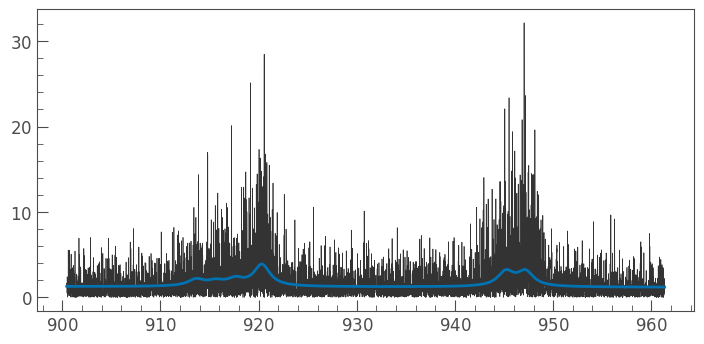

In [16]:
numax = star.numax
init =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(gaussian(f0_, 0, numax, 15.) * 2.0 * np.pi / 2.0) ,# l0 heights
       np.sqrt(gaussian(f1_, 1, numax, 15.) * 2.0 * np.pi / 2.0) ,# l1 heights
       np.sqrt(gaussian(f2_, 2, numax, 15.) * 2.0 * np.pi / 2.0) ,# l2 heights
       1.0 * np.sin(np.pi/2),       # projected splitting
       np.pi/2.,                    # inclination angle
       np.copy(phi_)]               # background parameters (in log)

mod = model(f, f0_, f1_, f2_)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod(init), lw=2)

# Build the priors in PyMC3

In [17]:
pm_model = pm.Model()

with pm_model:   
    # Frequencies
    f0 = pm.Normal('f0', mu=f0_, sigma=f0_e, testval=f0_, shape=len(f0_))
    f1 = pm.Normal('f1', mu=f1_, sigma=f1_e, testval=f1_, shape=len(f1_))
    f2 = pm.Normal('f2', mu=f2_, sigma=f2_e, testval=f2_, shape=len(f2_))
    
    # Mode linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init[3], shape=len(init[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init[4], shape=len(init[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init[5], shape=len(init[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=init[6], shape=len(init[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init[7], shape=len(init[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init[8], shape=len(init[8]))
    
    # Mode heights (determined by amplitude and linewidth)
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    # Rotation and inclination parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init[10])
    cosi = pm.Uniform('cosi', 0., 1.)
    
    # Detangled inclination and splitting
    i = pm.Deterministic('i', np.arccos(cosi))
    split = pm.Deterministic('split', xsplit/pm.math.sin(i))
    
    # Background treatment
    phi = pm.MvNormal('phi', mu=phi_, chol=phi_cholesky, testval=phi_, shape=len(phi_))
    
    #Model
    fit = mod([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi])
    
    like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)

In [18]:
with pm_model:
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [phi, cosi, xsplit, a2, a1, a0, g2, g1, g0, f2, f1, f0]
Sampling 4 chains: 100%|██████████| 4000/4000 [03:17<00:00, 20.24draws/s]


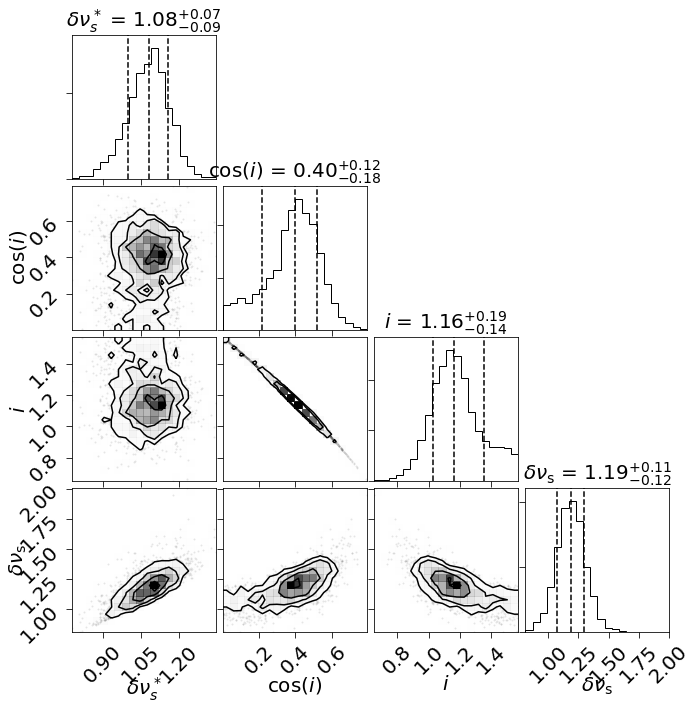

In [19]:
labels=['xsplit','cosi','i','split']
chain = np.array([trace[label] for label in labels])
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$i$',r'$\delta\nu_{\rm s}$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,show_titles=True)
plt.show()

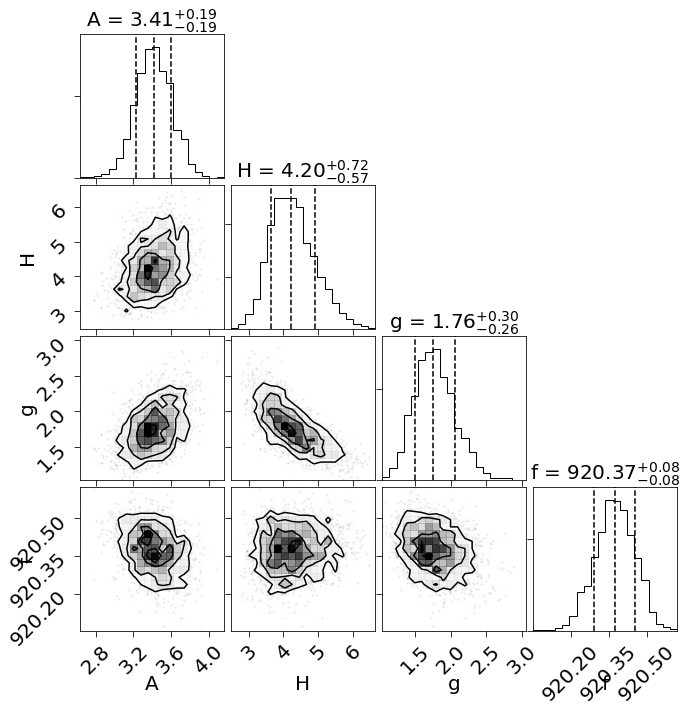

In [20]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

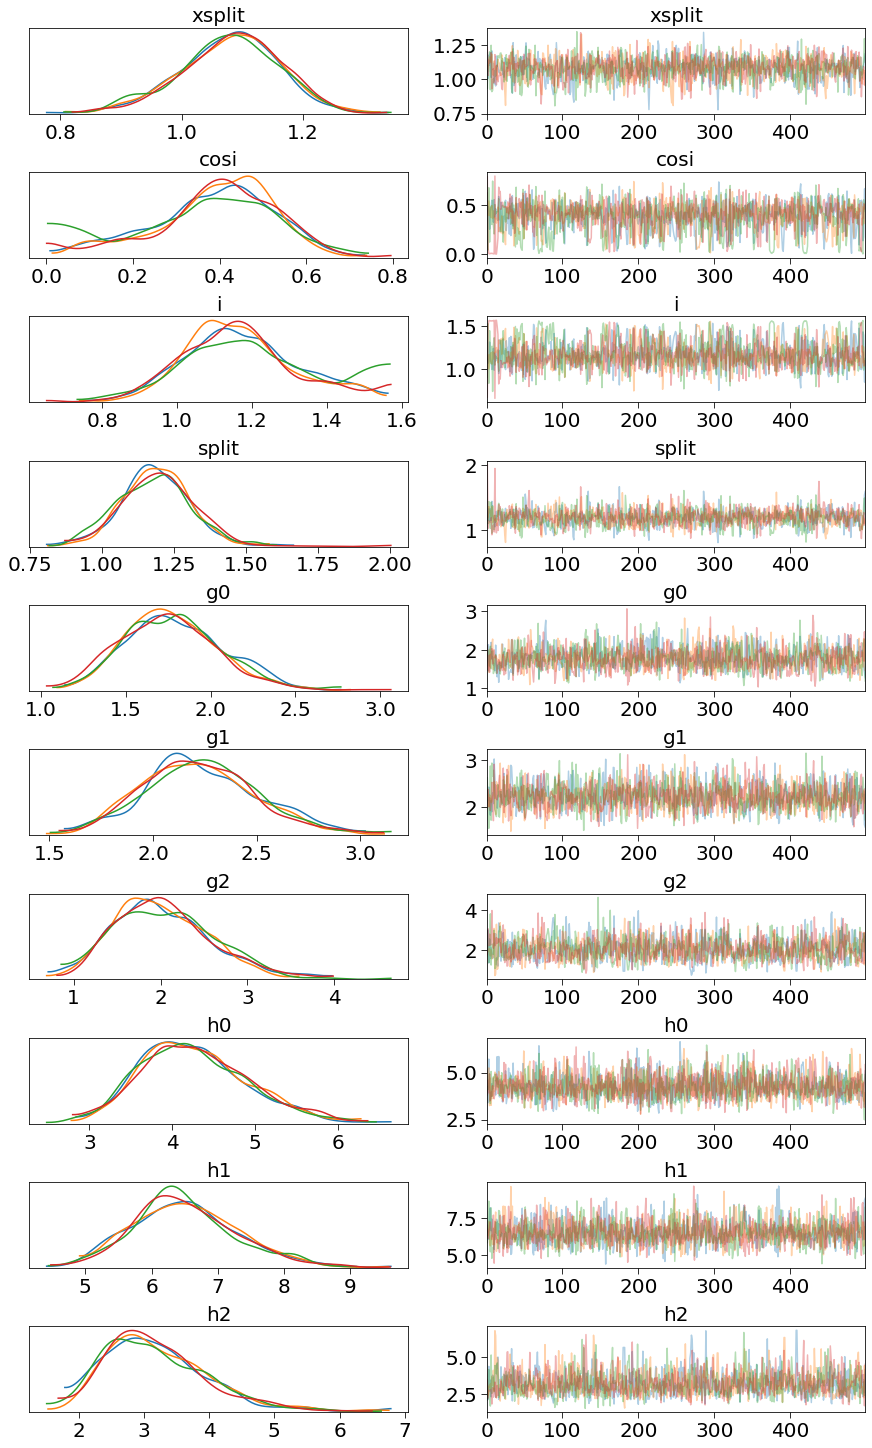

In [21]:
pm.traceplot(trace, var_names=['b','xsplit','cosi','i','split','g0','g1','g2','h0','h1','h2'])
plt.show()

In [22]:
cmap = sns.color_palette('plasma', n_colors = 10)

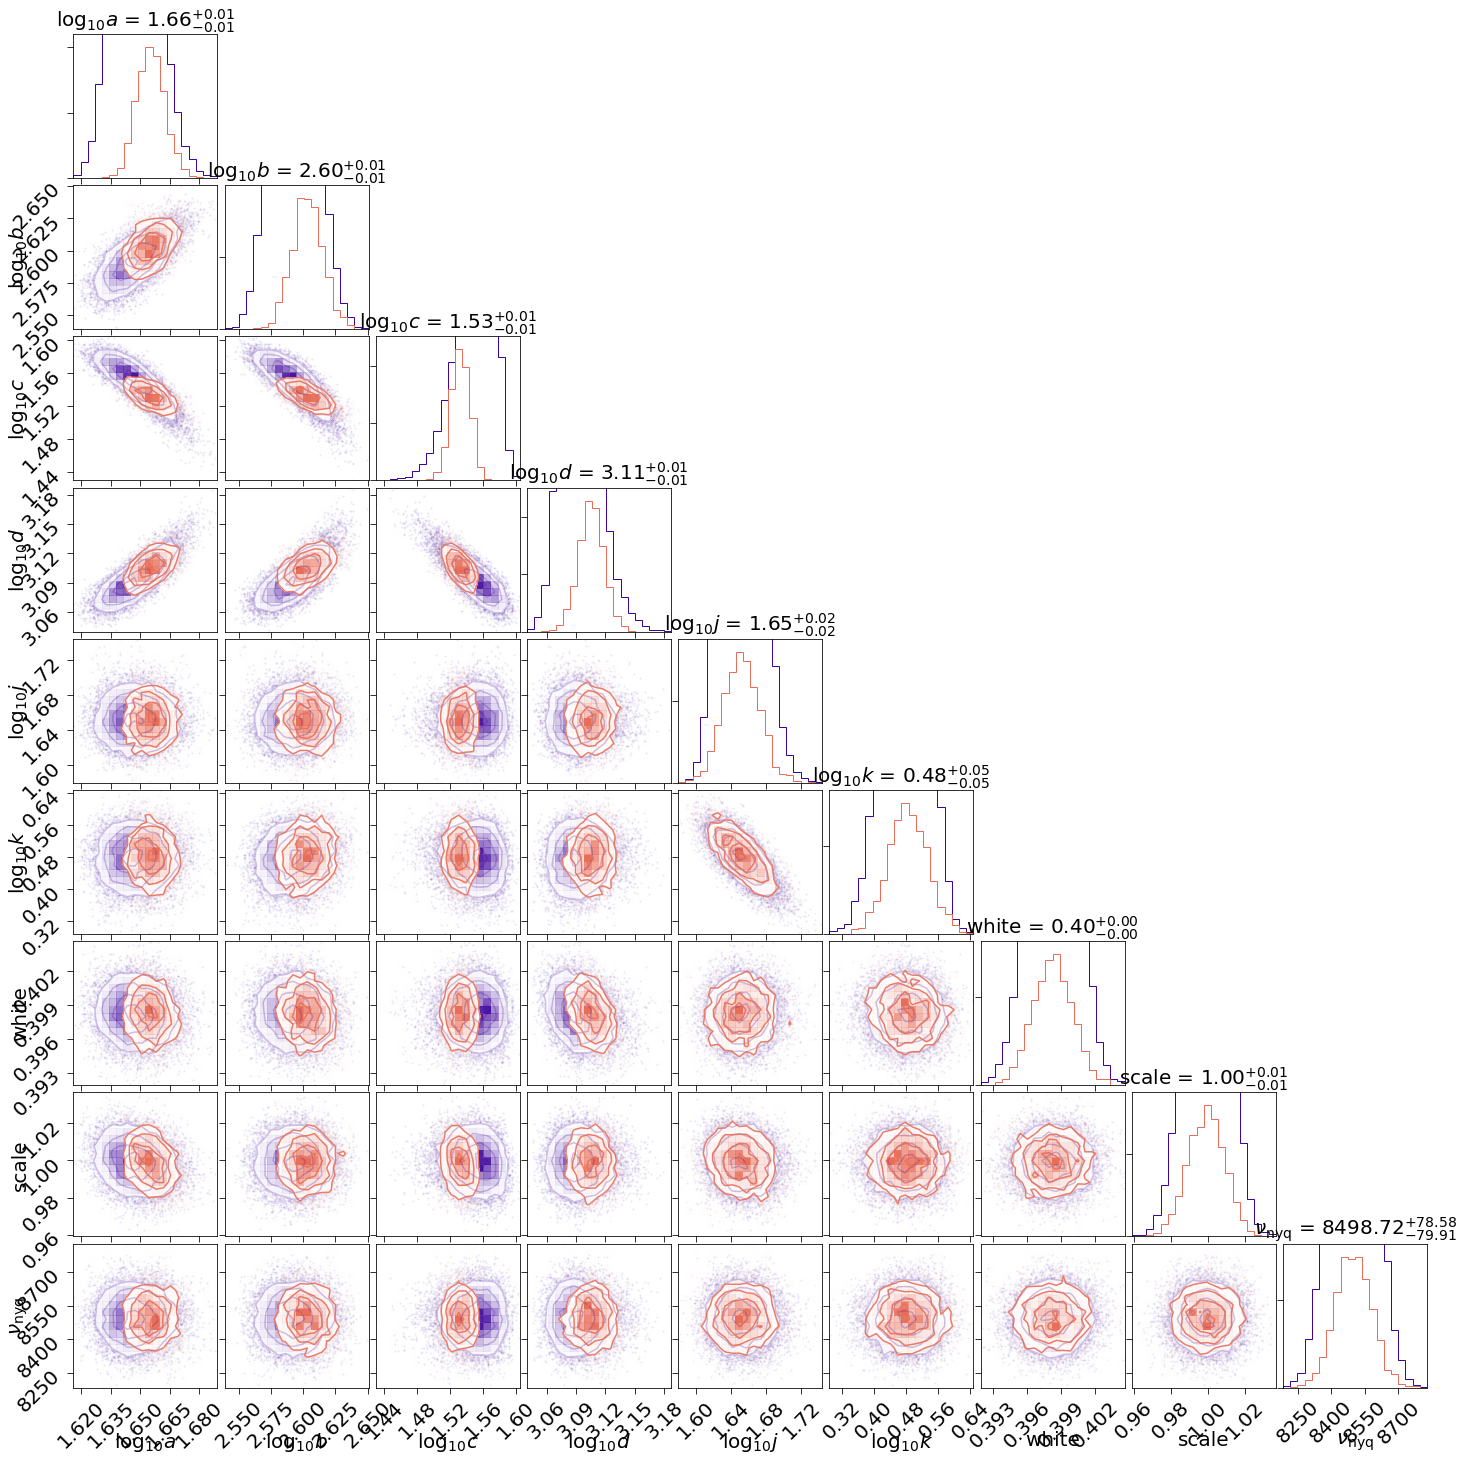

In [24]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

backchain = np.array([backfit[label] for label in labels]).T
phichain = np.array([trace['phi'][:,idx] for idx in range(len(phi_))]).T
limit = [(backfit[label].min(), backfit[label].max()) for label in labels]


fig = corner.corner(backchain, color=cmap[0], range=limit)
corner.corner(phichain, fig=fig, show_titles=True, labels=verbose, color=cmap[6], range=limit)

plt.show()

Looks like all the background parameters have been tightened up or remained within the priors. Always good to check!

### Now let's plot some output evaluation:

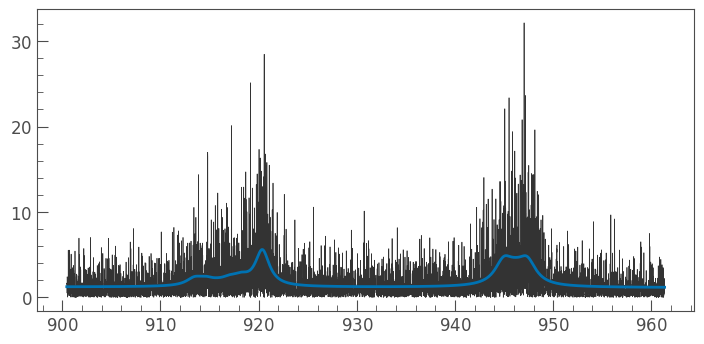

In [25]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'phi']
    res = np.array([np.median(trace[label],axis=0) for label in labels])
    ax.plot(f, mod(res), lw=2)

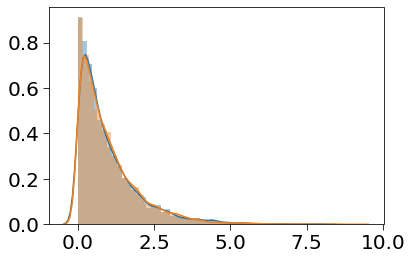

In [26]:
import seaborn as sns
sns.distplot(p/mod(res))
sns.distplot(np.random.chisquare(2, size=10000)/2)

Model looks reasonable, The model fits the $\chi_2^2$ noise, we're all good!